# Preprocessing:

In [ ]:
import pandas as pd
import re
import json

In [108]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [109]:
#Paths for Drive:
PATH_CHANNEL_MSG = "/content/drive/MyDrive/channel_messages.json" #File with Telegram chat messages.
PATH_CHANNEL_MSG1 = "/content/drive/MyDrive/channel_messages1.json" #File with Telegram chat messages (for autotest).
PATH_CHANNEL_MSG2 = "/content/drive/MyDrive/channel_messages2.json" #File with Telegram chat messages (another version).
PATH_LOGS = "/content/drive/MyDrive/logs.xlsx" #Table with logs for training a classifier.
PATH_AUDIOS = "/content/drive/MyDrive/wav_audio.js" #File with information about pre-recorded audios.
PATH_BOT_PHRASES = "/content/drive/MyDrive/bot_phrases.xlsx" #Table with information about bots and intent-labeled phrases.

In [1]:
# #Local Paths:
# PATH_CHANNEL_MSG = "channel_messages\channel_messages.json" #File with Telegram chat messages.
# PATH_CHANNEL_MSG1 = "channel_messages\channel_messages1.json" #File with Telegram chat messages (for autotest).
# PATH_CHANNEL_MSG2 = "channel_messages\channel_messages2.json" #File with Telegram chat messages (another version).
# PATH_LOGS = "tables\logs.xlsx" #Table with logs for training a classifier.
# PATH_AUDIOS = "project\src\wavAudios.js" #File with information about pre-recorded audios.
# PATH_BOT_PHRASES = "tables\bot_phrases.xlsx" #Table with information about bots and intent-labeled phrases.

In [ ]:
#logs = pd.read_excel(PATH_LOGS)
logs = pd.read_excel(PATH_LOGS)

In [111]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
stop_words.extend(["здравствуйте", "добрый", "доброе", "день", "вечер", "доброе", "здравствуй", "привет", "клиент", "уважаемый", "дорогой", "уважаемая", "дорогая"])

In [ ]:
stop_words

In [114]:
#Cleaning data from symbols and stop words, applying normalization:
def clean_data(text):
  text = re.sub("[(\d{1,2}\.)\.\?,!/]", "", text)
  text = text.lower().strip("")
  tokens = nltk.word_tokenize(text)
  clean_text = []
  for word in tokens:
      if word != "``":
          word = morph.parse(word)[0].normal_form
          if word not in stop_words:
            clean_text.append(word)
  clean_text = ' '.join(clean_text)
  return clean_text

In [115]:
logs['full_text'] = logs['full_text'].apply(clean_data)

In [116]:
logs

,full_text,intent
0,хотеть попросить подтвердить ваш запись приём ...,willYouCome
1,забрать авто тутанхамон розыгрыш золотой автом...,detailePromo
2,уточнять подтверждать запись сегодня : ждать н...,willYouCome
3,обращать ваш внимание задолженность кредит раз...,debt
4,ваш такси марка toyota номер ааа водитель алек...,taxi
...,...,...
1999,такси прибыть ожидать ваш вызов,taxi
2000,знать вчера встретить свой бывший парень казат...,common
2001,тинькофф банк рад предложить свой инвестироват...,financialServices
2002,внимание жених невеста приглашать бесплатный п...,detaileFreeExamination


<Axes: >

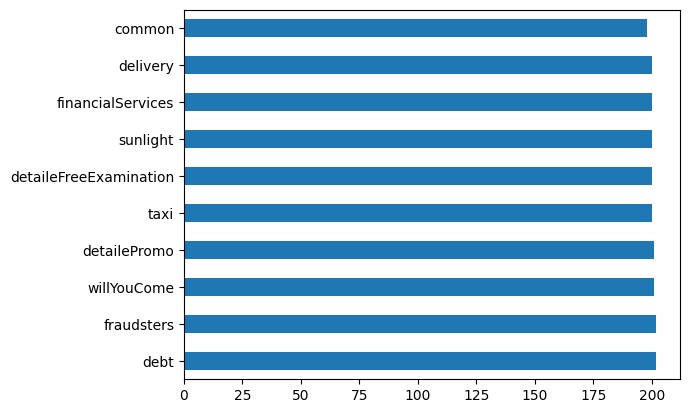

In [117]:
logs['intent'].value_counts().plot(kind='barh')

In [118]:
"""Since bots have specific lines for each of intents that do not differ inside of one intent,
it is possible to extract lines and intents from the special table. Levenshtein distance is
counted for each one to distinguish between lines and intents respectively."""

from nltk.metrics import edit_distance

def getting_intent_by_Levenshtein(table, test_msg):
  min_distance = 9999999999
  msg_intent = ""
  for msg in table["text"]:
    distance = edit_distance(test_msg, msg)
    if distance < min_distance:
      min_distance = distance
      id = table.index[table['text'] == msg][0]
  msg_intent = table.loc[id, "intent"]
  return msg_intent

In [119]:
bot_phrases = pd.read_excel(PATH_BOT_PHRASES)
bot_phrases['text'] = bot_phrases['text'].apply(clean_data)

In [120]:
bot_phrases

,bot,intent,text
0,Ника,sunlight,извинить понимать : это какой-то сдвиг реально...
1,Ника,common,записать передать
2,Ника,financialServices,ошибаться предложение обычно принять уточнять ...
3,Ника,common,ник виртуальный секретарь записывать всё говор...
4,Ника,delivery,подсказать заказ получить
5,Ника,detailePromo,ой интересно всё деталь ваш предложение записа...
6,Ника,detailePromo,обязательно подумать сколько ваш предложение д...
7,Ника,common,извинить неловкий вопрос человек робот
8,Ника,detailePromo,извинить почему это полезно
9,Ника,detailePromo,информация весь принять лично ваш предложение ...


# Classifier comparison to see the best one based on the accuracy:

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [166]:
accuracy_comparison = {}

In [167]:
# Naive Bayes:

X_train, X_test, y_train, y_test = train_test_split(logs['full_text'], logs['intent'], test_size=0.25)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

accuracy = metrics.accuracy_score(y_test, predicted)
accuracy_comparison[text_clf] = accuracy

                        precision    recall  f1-score   support

                common       1.00      0.53      0.69        51
                  debt       0.96      1.00      0.98        53
              delivery       0.91      0.98      0.94        41
detaileFreeExamination       0.95      1.00      0.97        56
          detailePromo       0.94      0.82      0.87        55
     financialServices       0.96      0.93      0.95        46
            fraudsters       0.94      0.96      0.95        49
              sunlight       0.77      1.00      0.87        55
                  taxi       0.96      1.00      0.98        44
           willYouCome       0.91      1.00      0.95        51

              accuracy                           0.92       501
             macro avg       0.93      0.92      0.92       501
          weighted avg       0.93      0.92      0.91       501



In [168]:
# Random Forest:

X_train, X_test, y_train, y_test = train_test_split(logs['full_text'], logs['intent'], test_size=0.25)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),
                     ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

accuracy = metrics.accuracy_score(y_test, predicted)
accuracy_comparison[text_clf] = accuracy

                        precision    recall  f1-score   support

                common       0.76      0.96      0.85        54
                  debt       0.96      1.00      0.98        52
              delivery       0.92      0.94      0.93        48
detaileFreeExamination       0.98      0.98      0.98        52
          detailePromo       0.98      0.85      0.91        60
     financialServices       0.98      0.96      0.97        49
            fraudsters       0.94      0.85      0.89        52
              sunlight       1.00      0.98      0.99        47
                  taxi       0.98      0.93      0.95        43
           willYouCome       1.00      1.00      1.00        44

              accuracy                           0.94       501
             macro avg       0.95      0.94      0.95       501
          weighted avg       0.95      0.94      0.94       501



In [169]:
# Decision Tree:

X_train, X_test, y_train, y_test = train_test_split(logs['full_text'], logs['intent'], test_size=0.25)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', DecisionTreeClassifier()),
                     ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

accuracy = metrics.accuracy_score(y_test, predicted)
accuracy_comparison[text_clf] = accuracy

                        precision    recall  f1-score   support

                common       0.75      0.96      0.84        50
                  debt       0.94      0.94      0.94        54
              delivery       0.91      0.87      0.89        45
detaileFreeExamination       0.88      0.93      0.91        46
          detailePromo       0.90      0.73      0.80        48
     financialServices       0.96      0.76      0.85        59
            fraudsters       0.84      0.88      0.86        48
              sunlight       0.94      1.00      0.97        47
                  taxi       0.98      0.94      0.96        54
           willYouCome       0.89      0.94      0.91        50

              accuracy                           0.89       501
             macro avg       0.90      0.90      0.89       501
          weighted avg       0.90      0.89      0.89       501



In [170]:
# Multi-layer Perceptron:

X_train, X_test, y_train, y_test = train_test_split(logs['full_text'], logs['intent'], test_size=0.25)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MLPClassifier()),
                     ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

accuracy = metrics.accuracy_score(y_test, predicted)
accuracy_comparison[text_clf] = accuracy

                        precision    recall  f1-score   support

                common       0.92      0.87      0.89        53
                  debt       0.96      0.98      0.97        45
              delivery       0.96      0.96      0.96        48
detaileFreeExamination       0.98      1.00      0.99        46
          detailePromo       0.92      0.92      0.92        49
     financialServices       0.94      0.98      0.96        47
            fraudsters       0.98      0.96      0.97        54
              sunlight       0.98      0.98      0.98        55
                  taxi       0.98      0.96      0.97        49
           willYouCome       0.98      1.00      0.99        55

              accuracy                           0.96       501
             macro avg       0.96      0.96      0.96       501
          weighted avg       0.96      0.96      0.96       501



In [171]:
# C-Support Vector:

X_train, X_test, y_train, y_test = train_test_split(logs['full_text'], logs['intent'], test_size=0.25)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC()),
                     ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

accuracy = metrics.accuracy_score(y_test, predicted)
accuracy_comparison[text_clf] = accuracy

                        precision    recall  f1-score   support

                common       0.79      1.00      0.88        45
                  debt       1.00      1.00      1.00        51
              delivery       0.94      0.97      0.96        35
detaileFreeExamination       1.00      0.98      0.99        49
          detailePromo       1.00      0.98      0.99        62
     financialServices       1.00      0.98      0.99        57
            fraudsters       1.00      0.96      0.98        45
              sunlight       1.00      1.00      1.00        48
                  taxi       0.98      0.89      0.93        53
           willYouCome       1.00      0.95      0.97        56

              accuracy                           0.97       501
             macro avg       0.97      0.97      0.97       501
          weighted avg       0.98      0.97      0.97       501



In [172]:
# K-Nearest Neighbors:

X_train, X_test, y_train, y_test = train_test_split(logs['full_text'], logs['intent'], test_size=0.25)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(3)),
                     ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

accuracy = metrics.accuracy_score(y_test, predicted)
accuracy_comparison[text_clf] = accuracy

                        precision    recall  f1-score   support

                common       0.76      0.76      0.76        37
                  debt       0.86      0.98      0.92        56
              delivery       0.94      0.96      0.95        50
detaileFreeExamination       0.98      0.98      0.98        54
          detailePromo       0.97      0.66      0.79        50
     financialServices       1.00      0.96      0.98        55
            fraudsters       0.97      0.95      0.96        59
              sunlight       0.89      1.00      0.94        51
                  taxi       0.94      1.00      0.97        46
           willYouCome       0.93      0.95      0.94        43

              accuracy                           0.93       501
             macro avg       0.92      0.92      0.92       501
          weighted avg       0.93      0.93      0.92       501



In [173]:
clf_best = max(accuracy_comparison, key = accuracy_comparison.get)
accur_best = accuracy_comparison[clf_best]

accuracy_comparison_df = pd.DataFrame({"classifier": [str(x[2]) for x in accuracy_comparison.keys()],
                                      "accuracy": accuracy_comparison.values()})
accuracy_comparison_df

,classifier,accuracy
0,MultinomialNB(),0.920160
1,RandomForestClassifier(),0.942116
2,DecisionTreeClassifier(),0.894212
3,MLPClassifier(),0.960080
4,SVC(),0.970060
5,KNeighborsClassifier(n_neighbors=3),0.926148


In [174]:
print(f"The best classifier in terms of its accuracy: {str(clf_best[2])}")

The best classifier in terms of its accuracy: SVC()


In [175]:
#Function to get intent labels with the best classifier. Using the whole log batch as training sample:

def predicting_intents_witn_best_classifier(clf, text):
  X_train = logs['full_text']
  y_train = logs['intent']

  clf.fit(X_train, y_train)
  predicted = text_clf.predict(text)[0]
  return predicted

In [176]:
#checking if it classifies correctly:

pred_sent = predicting_intents_witn_best_classifier(clf_best, [clean_data("Добрый день. Хотим пригласить вас на бесплатный осмотр. Вам интересно?")])
print("expected label: detaileFreeExamination, predicted label:", pred_sent)

expected label: detaileFreeExamination, predicted label: detaileFreeExamination


In [177]:
pred_sent = predicting_intents_witn_best_classifier(clf_best, [clean_data("Добрый день. Супермаркет Метро предлагает скидки на кисломолочные товары 50% до понедельника. Спешите на дни скидок в Метро!")])
print("expected label: detailePromo, predicted label:", pred_sent)

expected label: detailePromo, predicted label: detailePromo


In [178]:
pred_sent = predicting_intents_witn_best_classifier(clf_best, [clean_data("Здравствуйте, Вам звонит курьер по поводу доставки роллов, можете, пожалуйста, спуститься вниз за заказом?")])
print("expected label: delivery, predicted label:", pred_sent)

expected label: delivery, predicted label: delivery


In [179]:
pred_sent = predicting_intents_witn_best_classifier(clf_best, [clean_data("Иришка, привет! В Санлайте увидела золотые серёжки, как ты хотела - может, сходишь, глянешь? Недорогие, вроде..")])
print("expected label: common, predicted label:", pred_sent)

expected label: common, predicted label: common


In [180]:
pred_sent = predicting_intents_witn_best_classifier(clf_best, [clean_data("Получите карту гостя и 1000 бонусов в Метро на будущие покупки! Только до 23 апреля.")])
print("expected label: detailePromo, predicted label:", pred_sent)

expected label: detailePromo, predicted label: detailePromo


# Test for the real conversations (intents are classified):

In [181]:
def getting_parced_msg_table(table_path):
 #Downloading .json file:
  with open(table_path) as f:
    messages = {}
    msgs = json.load(f)

# Getting message content from the .json file:
  k = 0
  bot_names = ["Ника: ", "Скай: ", "Сергей: ", "Дарья: "]
  for msg in msgs:
    if msg["message"].split(" ")[0] == "Звонок" and msg["message"] not in messages.values():
      message = msg["message"]
      for name in bot_names:
        message = message.replace(name, "Бот: ")
      messages[k] = message
      k += 1

# Creating a table with messages:
  idxs = []
  msg_bot = []
  msg_client = []
  bot_hi = ["Алло.\n", "Здравствуйте.\n", "Да, алло, слушаю.\n", "Алло, слушаю.\n", "Слушаю Вас.\n", "Да, слушаю.\n", 'Здравствуйте, внимательно слушаю.\n']
  call_ended = "[Звонок закончен]"
  for i in range(len(messages)):
    k = 0
    while messages[i] != "":
      bot = messages[i].split("Бот: ")[1].split("Абонент: ")[0]
      if bot not in bot_hi and k == 0:
        msg_bot.append(bot)
        idxs.append(i)
        k += 1
      messages[i] = messages[i].replace(messages[i].split("Абонент: ")[0], "", 1)
      client = messages[i].split("Абонент: ")[1].split("Бот: ")[0]
      if client != call_ended and k == 0:
        msg_client.append(client)
      messages[i] = messages[i].replace(messages[i].split("Бот: ")[0], "", 1)
  pd_msgs_parsed = pd.DataFrame({"dialogue": idxs, "msg_client": msg_client, "msg_bot": msg_bot})
  return pd_msgs_parsed

In [182]:
pd_parced = getting_parced_msg_table(PATH_CHANNEL_MSG2)

In [199]:
pd_parced[65:75]

,dialogue,msg_client,msg_bot
65,65,яндекс такси ваш машинка подъехать номер пятьс...,"Я Ника, виртуальный секретарь. Записываю все, ..."
66,66,звонить клиентский служба газпромбанк предлага...,"Если я не ошибаюсь, то на предложения обычно п..."
67,67,выяснить ещё сей пора являться альфа банк хоте...,"Если я не ошибаюсь, то на предложения обычно п..."
68,68,предлагать современный условие новый карта бан...,"Если я не ошибаюсь, то на предложения обычно п..."
69,69,клиентский служба сбербанк ваш имя выпустить н...,"Абонент сейчас не может ответить, а я Ника, ви..."
70,70,уникальный предложение магазин санлайта дмитри...,"Извините, но я не совсем понимаю: это что, как..."
71,71,мочь получить бесплатный подвеска магазин санл...,"Извините, но я не совсем понимаю: это что, как..."
72,72,магазин санлайта сегодня бесплатный подвеска п...,"Я Ника, виртуальный секретарь. Записываю все, ..."
73,73,предложение магазин санлайта скидка серебряный...,"Извините, но я не совсем понимаю: это что, как..."
74,74,магазин санлайта новый акция приходить получит...,"Извините, но я не совсем понимаю: это что, как..."


In [184]:
def comparison_table(parced_table):

#Classifying user messages to get the intent behind them:
  intents_client = []
  parced_table["msg_client"] = parced_table["msg_client"].apply(clean_data)
  for msg in parced_table["msg_client"]:
    intents_client.append(predicting_intents_witn_best_classifier(clf_best, [clean_data(msg)]))

#Getting intent from bot messages using Levenshtein distance and table with bot responses:
  intents_bot = []
  for msg in parced_table["msg_bot"]:
    intents_bot.append(getting_intent_by_Levenshtein(bot_phrases, msg))

#Creating the comparison table:
  intent_comparison = pd.DataFrame({"client_messages": pd_parced["msg_client"],
                                   "client_intents": intents_client,
                                   "bot_responses": pd_parced["msg_bot"],
                                   "bot_intents": intents_bot})
  return intent_comparison

In [185]:
compar_table = comparison_table(pd_parced)

In [200]:
compar_table[65:75]

,client_messages,client_intents,bot_responses,bot_intents
65,яндекс такси ваш машинка подъехать номер пятьс...,taxi,"Я Ника, виртуальный секретарь. Записываю все, ...",common
66,звонить клиентский служба газпромбанк предлага...,financialServices,"Если я не ошибаюсь, то на предложения обычно п...",financialServices
67,выяснить ещё сей пора являться альфа банк хоте...,financialServices,"Если я не ошибаюсь, то на предложения обычно п...",financialServices
68,предлагать современный условие новый карта бан...,financialServices,"Если я не ошибаюсь, то на предложения обычно п...",financialServices
69,клиентский служба сбербанк ваш имя выпустить н...,fraudsters,"Абонент сейчас не может ответить, а я Ника, ви...",common
70,уникальный предложение магазин санлайта дмитри...,sunlight,"Извините, но я не совсем понимаю: это что, как...",sunlight
71,мочь получить бесплатный подвеска магазин санл...,sunlight,"Извините, но я не совсем понимаю: это что, как...",sunlight
72,магазин санлайта сегодня бесплатный подвеска п...,sunlight,"Я Ника, виртуальный секретарь. Записываю все, ...",common
73,предложение магазин санлайта скидка серебряный...,sunlight,"Извините, но я не совсем понимаю: это что, как...",sunlight
74,магазин санлайта новый акция приходить получит...,sunlight,"Извините, но я не совсем понимаю: это что, как...",sunlight


# Test for the pre-recorded audios (intents are extracted from the table):

In [78]:
#Reading js-file:
texts = []
intents = []
with open(PATH_AUDIOS) as f:
  for line in f:
    line = line.strip('\"')
    texts.extend(re.findall(r"(?<=text: ).*(?=,)", line))
    intents.extend(re.findall(r'(?<=intent: ").*(?=",)', line))

#Creating the table with info about pre-recorded audio information:
audios_table = pd.DataFrame({"text": texts,
                             "intent": intents})

In [79]:
audios_table['text'] = audios_table['text'].apply(clean_data)

In [80]:
audios_table.head(10)

,text,intent
0,здравствуйте беспокоить салон красота милан на...,willYouCome
1,здравствуйте приветствовать юридический фирма ...,debt
2,здравствуйте говорить голосовой помощник алиса...,detailePromo
3,здравствуйте магазин подружка сообщать конец м...,detailePromo
4,здравствуйте удобно говорить приветствовать ме...,delivery
5,добрый день заявка оставить наш официальный са...,financialServices
6,здравствуйте приветствовать служба безопасност...,fraudsters
7,здравствуйте менеджер продажа ангелина наш маг...,sunlight
8,добрый день приветствовать служба заказ такси ...,taxi
9,здравствуйте студия красота даймонд администра...,willYouCome


In [81]:
def getting_parced_msg_table(table_path):
 #Downloading .json file:
  with open(table_path) as f:
    messages = {}
    msgs = json.load(f)

# Getting message content from the .json file:
  k = 0
  bot_names = ["Ника: ", "Скай: ", "Сергей: ", "Дарья: "]
  for msg in msgs:
    if msg["message"].split(" ")[0] == "Звонок" and msg["message"] not in messages.values():
      message = msg["message"]
      for name in bot_names:
        message = message.replace(name, "Бот: ")
      messages[k] = message
      k += 1

# Creating a table with messages:
  idxs = []
  msg_bot = []
  msg_client = []
  bot_hi = ["Алло.\n", "Здравствуйте.\n", "Да, алло, слушаю.\n"]
  call_ended = "[Звонок закончен]"
  for i in range(len(messages)):
    while messages[i] != "":
      bot = messages[i].split("Бот: ")[1].split("Абонент: ")[0]
      if bot not in bot_hi:
        msg_bot.append(bot)
        idxs.append(i)
      messages[i] = messages[i].replace(messages[i].split("Абонент: ")[0], "", 1)
      client = messages[i].split("Абонент: ")[1].split("Бот: ")[0]
      if client != call_ended:
        msg_client.append(client)
      messages[i] = messages[i].replace(messages[i].split("Бот: ")[0], "", 1)
  pd_msgs_parsed = pd.DataFrame({"dialogue": idxs, "msg_client": msg_client, "msg_bot": msg_bot})
  return pd_msgs_parsed

In [88]:
pd_parced = getting_parced_msg_table(PATH_CHANNEL_MSG1)

In [89]:
def comparison_table(parced_table):

#Getting intent from the client messages via the table with pre-recorded audios:
  intents_client = []
  parced_table["msg_client"] = parced_table["msg_client"].apply(clean_data)
  for msg in parced_table["msg_client"]:
    intents_client.append(getting_intent_by_Levenshtein(audios_table, msg))

#Getting intent from bot messages using Levenshtein distance and table with bot responses:
  intents_bot = []
  for msg in parced_table["msg_bot"]:
    intents_bot.append(getting_intent_by_Levenshtein(bot_phrases, msg))

#Creating the comparison table:
  intent_comparison = pd.DataFrame({"client_messages": pd_parced["msg_client"],
                                   "client_intents": intents_client,
                                   "bot_responses": pd_parced["msg_bot"],
                                   "bot_intents": intents_bot})
  return intent_comparison

In [90]:
compar_table = comparison_table(pd_parced)

In [91]:
compar_table

,client_messages,client_intents,bot_responses,bot_intents
0,здравствуйте пиццерия бостон администратор але...,delivery,"Я Ника, виртуальный секретарь. Записываю все, ...",common
1,здравствуйте приветствовать служба безопасност...,fraudsters,"Извините, а абонент сейчас ответить не может. ...",common


# Evaluation:

In [92]:
# ----------------------------------------------------------------------------------------------------
#    Evaluation rules:
#  + 1 if the intents coincide;
#  - 1 if bot detected incorrect intent of the specific type (all the intents besides common);
#    0 if bot responded with a common line to the intent of the specific type (besides taxi and fraudsters intents);
# + 0.5 if bot responded with a common line to the taxi or fraudsters intent (these intents do not have specific lines);
# The result is corrected by the accuracy of the classifier.
# ----------------------------------------------------------------------------------------------------

In [101]:
def intent_recognition_evaluation(accuracy, table):
  counter = 0
  positive_cases = 0
  neutral_cases = 0
  negative_cases = 0
  cnt = 0

#Comparing client_intent which is row[2] with bot_intent which is row[4]:
  for row in table.itertuples():
    client_intent = row[2]
    bot_intent = row[4]
    if client_intent == bot_intent:
      counter += 1
      positive_cases += 1
    elif (client_intent == "fraudsters" or client_intent == "taxi") and bot_intent == "common":
      counter += 0.95
      positive_cases += 1
    elif (client_intent != "fraudsters" and client_intent != "taxi") and bot_intent == "common":
        neutral_cases +=1
        counter += 0
    elif client_intent != bot_intent:
      negative_cases += 1
      counter -= 1
    cnt += 1

  if accuracy:
    eval = (counter/cnt) * (3 - accuracy)
  else:
    eval = (counter/cnt)

  if eval >= 0.75:
    status = "Success"
  elif eval < 0.75 and eval >= 0.4:
    status = "Partial success"
  else:
    status = "Failure"

  return f"Evaluation score is {eval}:\n\n{positive_cases} intent(s) — correct,\n{negative_cases} intents(s) — incorrect\nand {neutral_cases} case(s) — no specific responses. Evaluation status: {status}"

In [102]:
eval = intent_recognition_evaluation(accur_best, compar_table)

0.95
2


In [103]:
print(eval)

Evaluation score is 0.9670658682634731:

1 intent(s) — correct,
0 intents(s) — incorrect
and 1 case(s) — no specific responses. Evaluation status: Success
